In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

In [8]:
construction_cost = pd.read_csv('../data/construction_cost.csv', index_col=0)
income = pd.read_csv('../data/income.csv', index_col=0)
living_space = pd.read_csv('../data/living_space.csv', index_col=0)
rent = pd.read_csv('../data/rent.csv', index_col=0)
population = pd.read_csv('../data/population.csv', index_col=0)

#### compute living space index per population index

In [18]:
((living_space.index == population.index) & (living_space.index == rent.index)).all()

True

In [19]:
ls_pp = living_space["total"] / population["total"]
# convert to index again
ls_pp = (ls_pp / ls_pp.loc[2015]) * 100
ls_pp_feature = ls_pp.values.reshape(-1, 1)

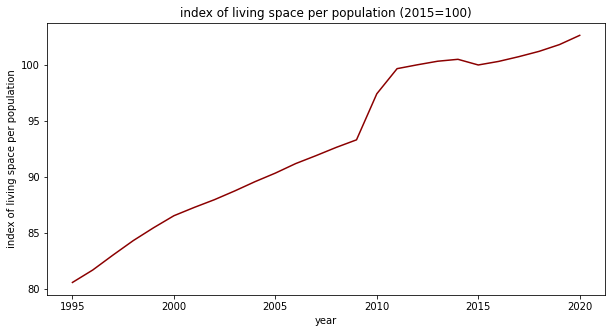

In [27]:
plt.figure(figsize=(10, 5))

plt.plot(rent.index, ls_pp, color='darkred')
    
plt.xlabel('year')
plt.ylabel('index of living space per population')
plt.title('index of living space per population (2015=100)');

#### compute regression using the living space per population

In [24]:
observation = rent['rent'].values.reshape(-1 ,1)

fit = LinearRegression().fit(ls_pp_feature, observation)
prediction = fit.predict(ls_pp_feature)
coefs = fit.coef_
print('coef: ', round(coefs.item(), 4))

mse = np.mean((observation - prediction)**2)

coef:  1.1596


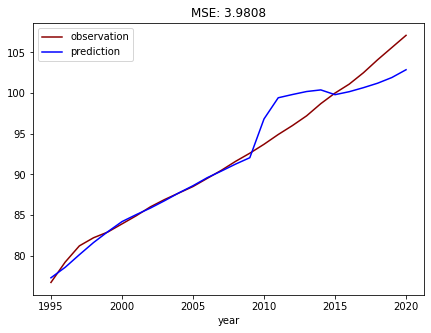

In [26]:
plt.figure(figsize=(7, 5))
plt.plot(rent.index, observation, color='darkred', label='observation')
plt.plot(rent.index, prediction, color='blue', label='prediction')
plt.legend()
plt.xlabel('year')
plt.title('MSE: ' + str(round(mse, 4)))
plt.show();

#### add construction cost (only available from 2000 on)

In [31]:
cc_feature = construction_cost['total cost'].values.reshape(-1, 1)
features = np.hstack((ls_pp_feature[5:], cc_feature))

observation = rent['rent'].values.reshape(-1 ,1)[5:]

fit = LinearRegression().fit(features, observation)
prediction = fit.predict(features)
coefs = fit.coef_

mse = np.mean((observation - prediction)**2)

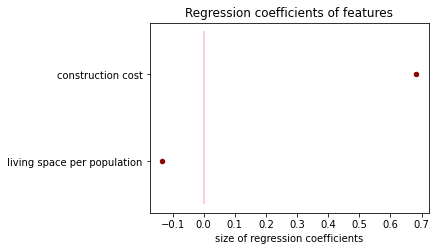

In [32]:
feature_names = ['living space per population', 'construction cost']

plt.figure(figsize=(5, 3.5))
y = np.arange(1, len(feature_names)+1, 1)
plt.scatter(coefs, y, s=20, color='darkred')
plt.yticks(y, labels=feature_names)
plt.vlines(0, 0.5, len(feature_names)+0.5, color='pink')
plt.xlabel('size of regression coefficients')
plt.title('Regression coefficients of features')
plt.show();

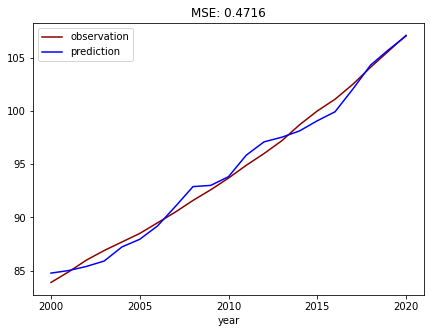

In [38]:
plt.figure(figsize=(7, 5))
plt.plot(construction_cost.index, observation, color='darkred', label='observation')
plt.plot(construction_cost.index, prediction, color='blue', label='prediction')
plt.legend()
plt.xticks([2000, 2005, 2010, 2015, 2020])
plt.xlabel('year')
plt.title('MSE: ' + str(round(mse, 4)))
plt.show();

#### use only construction cost

In [39]:
fit = LinearRegression().fit(cc_feature, observation)
prediction = fit.predict(cc_feature)
coefs = fit.coef_
print('coef: ', round(coefs.item(), 4))

mse = np.mean((observation - prediction)**2)

coef:  0.6185


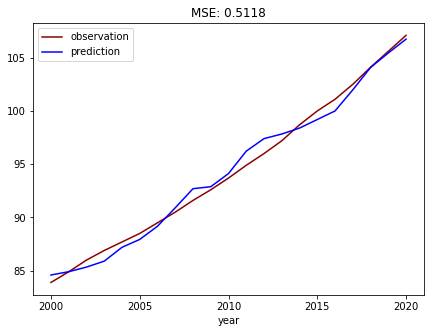

In [40]:
plt.figure(figsize=(7, 5))
plt.plot(construction_cost.index, observation, color='darkred', label='observation')
plt.plot(construction_cost.index, prediction, color='blue', label='prediction')
plt.legend()
plt.xticks([2000, 2005, 2010, 2015, 2020])
plt.xlabel('year')
plt.title('MSE: ' + str(round(mse, 4)))
plt.show();

#### try to predict the last x years

In [92]:
years_to_predict = np.arange(1, 7)
ls_pp_coeffs = []
cc_coeffs = []
mses = []

features = np.hstack((ls_pp_feature[5:], cc_feature))
observation = rent['rent'].values.reshape(-1 ,1)[5:]

for year in years_to_predict:

    fit = LinearRegression().fit(features[:-year], observation[:-year])
    prediction = fit.predict(features)

    coefs = fit.coef_
    ls_pp_coeffs.append(coefs[0, 0])
    cc_coeffs.append(coefs[0, 1])

    mse = np.mean((observation - prediction)**2)
    mses.append(mse)

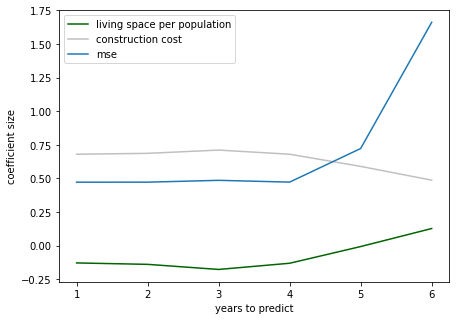

In [93]:
plt.figure(figsize=(7, 5))
plt.plot(years_to_predict, ls_pp_coeffs, color='darkgreen', label='living space per population')
plt.plot(years_to_predict, cc_coeffs, color='silver', label='construction cost')
plt.plot(years_to_predict, mses, label='mse')
plt.legend()
plt.xlabel('years to predict')
plt.ylabel('coefficient size')
plt.show();

In [14]:
#hypothesis test: did rent increase significantly in 2020